In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

3


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    #ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from sklearn.ensemble import RandomForestRegressor
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X[np.isnan(X)]=-999    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i,trainX,trainy,validX,validy, max_features,max_depth,min_samples_leaf,n_estimators=1000 ):
        models=[]
        scores=[]
        gbm = RandomForestRegressor(n_estimators=n_estimators,
                    max_features=max_features,max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,n_jobs=16, verbose=1)
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X[np.isnan(X)]=-999       
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=-999   
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 1000}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [25]:
j=FOLD
validpreds={}

In [26]:
p = Pool(2,maxtasksperchild=1)

In [27]:
results=p.map(ff, range(1,40),chunksize=1)

3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 7461 records out of 7461 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(7461, 1, 18) (7461, 7, 72) (7461, 1) (7461, 1)


(7461, 522) (7461,) (7461,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.2s


4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 8290 records out of 8290 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(8290, 1, 18) (8290, 7, 72) (8290, 1) (8290, 1)


(8290, 522) (8290,) (8290,)


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   36.7s


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   44.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.6min


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.8min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.9min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  3.2min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.8min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.4s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    3.1s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   10.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   13.1s finished


0.035967777096059764 0.2806869983719106


[0.2806869983719106]


-1 mean score 0.2806869983719106


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.0945942084702


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889982  0.039128  0.087339    7  2017-04-16
472     2.507290  2.528595 -0.021304  0.085654    1  2017-04-17
473     2.661330  2.624460  0.036870  0.133510    2  2017-04-18
474     2.754815  2.743335  0.011480  0.131527    3  2017-04-19
475     2.713762  2.720104 -0.006343  0.094712    4  2017-04-20
476     2.999000  2.978688  0.020312  0.062295    5  2017-04-21
477     3.075529  3.064506  0.011023  0.067123    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0945942084702


pred         y     error    error2  day        date
dayidx                                                         
471     2.889982  2.929110  0.039128  0.087339    7  2017-04-16
472     2.528595  2.507290 -0.021304  0.085654    1  2017-04-17
473     2.624460  2.661330  0.036870  0.133510    2  2017-04-18
474     2.743335  2.754815  0.011480  0.131527    3  2017-04-19
475     2.720104  2.713762 -0.006343  0.094712    4  2017-04-20
476     2.978688  2.999000  0.020312  0.062295    5  2017-04-21
477     3.064506  3.075529  0.011023  0.067123    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 9119 records out of 9119 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(9119, 1, 18) (9119, 7, 72) (9119, 1) (9119, 1)


(9119, 522) (9119,) (9119,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    8.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  4.0min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    3.1s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.6s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   10.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   13.3s finished


0.03604989033430539 0.28294686066880986


[0.28294686066880986]


-1 mean score 0.28294686066880986


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.0929179719638


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886427  0.042683  0.095226    7  2017-04-16
472     2.507290  2.530552 -0.023261  0.079599    1  2017-04-17
473     2.661330  2.643077  0.018253  0.096885    2  2017-04-18
474     2.754815  2.719402  0.035413  0.108685    3  2017-04-19
475     2.713762  2.730829 -0.017068  0.124754    4  2017-04-20
476     2.999000  2.976631  0.022368  0.072242    5  2017-04-21
477     3.075529  3.055235  0.020294  0.073035    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0929179719638


pred         y     error    error2  day        date
dayidx                                                         
471     2.886427  2.929110  0.042683  0.095226    7  2017-04-16
472     2.530552  2.507290 -0.023261  0.079599    1  2017-04-17
473     2.643077  2.661330  0.018253  0.096885    2  2017-04-18
474     2.719402  2.754815  0.035413  0.108685    3  2017-04-19
475     2.730829  2.713762 -0.017068  0.124754    4  2017-04-20
476     2.976631  2.999000  0.022368  0.072242    5  2017-04-21
477     3.055235  3.075529  0.020294  0.073035    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 9948 records out of 9948 records


no valid set


1575


0


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   41.5s


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(9948, 1, 18) (9948, 7, 72) (9948, 1) (9948, 1)


(9948, 522) (9948,) (9948,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.7s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   44.2s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.6min


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.8min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.9min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.7min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.9s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.2s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    9.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   11.7s finished


0.036112984529971213 0.28358307415906525


[0.28358307415906525]


-1 mean score 0.28358307415906525


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.0924137565175


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885836  0.043274  0.098898    7  2017-04-16
472     2.507290  2.532319 -0.025028  0.087794    1  2017-04-17
473     2.661330  2.643023  0.018306  0.089025    2  2017-04-18
474     2.754815  2.738785  0.016030  0.088110    3  2017-04-19
475     2.713762  2.717569 -0.003808  0.124623    4  2017-04-20
476     2.999000  2.980030  0.018970  0.082567    5  2017-04-21
477     3.075529  3.061191  0.014338  0.075879    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  3.2min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0924137565175


pred         y     error    error2  day        date
dayidx                                                         
471     2.885836  2.929110  0.043274  0.098898    7  2017-04-16
472     2.532319  2.507290 -0.025028  0.087794    1  2017-04-17
473     2.643023  2.661330  0.018306  0.089025    2  2017-04-18
474     2.738785  2.754815  0.016030  0.088110    3  2017-04-19
475     2.717569  2.713762 -0.003808  0.124623    4  2017-04-20
476     2.980030  2.999000  0.018970  0.082567    5  2017-04-21
477     3.061191  3.075529  0.014338  0.075879    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 10777 records out of 10777 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(10777, 1, 18) (10777, 7, 72) (10777, 1) (10777, 1)


(10777, 522) (10777,) (10777,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  4.0min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.8s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   40.4s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.5s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.5s finished


0.03638854081753801 0.2876949672612129


[0.2876949672612129]


-1 mean score 0.2876949672612129


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0924053799993


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893588  0.035522  0.108277    7  2017-04-16
472     2.507290  2.536517 -0.029226  0.092030    1  2017-04-17
473     2.661330  2.643060  0.018270  0.107016    2  2017-04-18
474     2.754815  2.739178  0.015636  0.082366    3  2017-04-19
475     2.713762  2.721376 -0.007614  0.082368    4  2017-04-20
476     2.999000  2.953909  0.045090  0.083400    5  2017-04-21
477     3.075529  3.069971  0.005558  0.091381    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0924053799993


pred         y     error    error2  day        date
dayidx                                                         
471     2.893588  2.929110  0.035522  0.108277    7  2017-04-16
472     2.536517  2.507290 -0.029226  0.092030    1  2017-04-17
473     2.643060  2.661330  0.018270  0.107016    2  2017-04-18
474     2.739178  2.754815  0.015636  0.082366    3  2017-04-19
475     2.721376  2.713762 -0.007614  0.082368    4  2017-04-20
476     2.953909  2.999000  0.045090  0.083400    5  2017-04-21
477     3.069971  3.075529  0.005558  0.091381    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 11606 records out of 11606 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(11606, 1, 18) (11606, 7, 72) (11606, 1) (11606, 1)


(11606, 522) (11606,) (11606,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.6min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   41.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.7min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.9min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.7min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.5s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.5s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.6s finished


0.035873431687979504 0.28099989334528647


[0.28099989334528647]


-1 mean score 0.28099989334528647


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.098434734131


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889128  0.039982  0.126406    7  2017-04-16
472     2.507290  2.553642 -0.046351  0.096782    1  2017-04-17
473     2.661330  2.644055  0.017275  0.109430    2  2017-04-18
474     2.754815  2.741608  0.013207  0.097705    3  2017-04-19
475     2.713762  2.720081 -0.006319  0.084537    4  2017-04-20
476     2.999000  2.973257  0.025743  0.058004    5  2017-04-21
477     3.075529  3.094219 -0.018690  0.116180    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.098434734131


pred         y     error    error2  day        date
dayidx                                                         
471     2.889128  2.929110  0.039982  0.126406    7  2017-04-16
472     2.553642  2.507290 -0.046351  0.096782    1  2017-04-17
473     2.644055  2.661330  0.017275  0.109430    2  2017-04-18
474     2.741608  2.754815  0.013207  0.097705    3  2017-04-19
475     2.720081  2.713762 -0.006319  0.084537    4  2017-04-20
476     2.973257  2.999000  0.025743  0.058004    5  2017-04-21
477     3.094219  3.075529 -0.018690  0.116180    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  3.0min


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 12435 records out of 12435 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(12435, 1, 18) (12435, 7, 72) (12435, 1) (12435, 1)


(12435, 522) (12435,) (12435,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.2s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   38.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.9min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.7s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.8s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.6s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   11.2s finished


0.035513871887603 0.2777640594325603


[0.2777640594325603]


-1 mean score 0.2777640594325603


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0937535714562


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932896 -0.003786  0.132112    7  2017-04-16
472     2.507290  2.567790 -0.060500  0.102606    1  2017-04-17
473     2.661330  2.664453 -0.003124  0.104280    2  2017-04-18
474     2.754815  2.749580  0.005234  0.094429    3  2017-04-19
475     2.713762  2.722885 -0.009123  0.089723    4  2017-04-20
476     2.999000  2.963898  0.035101  0.058594    5  2017-04-21
477     3.075529  3.071721  0.003808  0.074530    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0937535714562


pred         y     error    error2  day        date
dayidx                                                         
471     2.932896  2.929110 -0.003786  0.132112    7  2017-04-16
472     2.567790  2.507290 -0.060500  0.102606    1  2017-04-17
473     2.664453  2.661330 -0.003124  0.104280    2  2017-04-18
474     2.749580  2.754815  0.005234  0.094429    3  2017-04-19
475     2.722885  2.713762 -0.009123  0.089723    4  2017-04-20
476     2.963898  2.999000  0.035101  0.058594    5  2017-04-21
477     3.071721  3.075529  0.003808  0.074530    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 13264 records out of 13264 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(13264, 1, 18) (13264, 7, 72) (13264, 1) (13264, 1)


(13264, 522) (13264,) (13264,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   37.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.8min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.6min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.5s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.4s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.2s finished


0.03653692168856379 0.2880325989814468


[0.2880325989814468]


-1 mean score 0.2880325989814468


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0973365948667


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910046  0.019064  0.088426    7  2017-04-16
472     2.507290  2.554361 -0.047071  0.136920    1  2017-04-17
473     2.661330  2.667124 -0.005795  0.126133    2  2017-04-18
474     2.754815  2.747265  0.007550  0.095857    3  2017-04-19
475     2.713762  2.717062 -0.003301  0.094307    4  2017-04-20
476     2.999000  2.965258  0.033741  0.068129    5  2017-04-21
477     3.075529  3.061237  0.014293  0.071585    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0973365948667


pred         y     error    error2  day        date
dayidx                                                         
471     2.910046  2.929110  0.019064  0.088426    7  2017-04-16
472     2.554361  2.507290 -0.047071  0.136920    1  2017-04-17
473     2.667124  2.661330 -0.005795  0.126133    2  2017-04-18
474     2.747265  2.754815  0.007550  0.095857    3  2017-04-19
475     2.717062  2.713762 -0.003301  0.094307    4  2017-04-20
476     2.965258  2.999000  0.033741  0.068129    5  2017-04-21
477     3.061237  3.075529  0.014293  0.071585    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 14093 records out of 14093 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(14093, 1, 18) (14093, 7, 72) (14093, 1) (14093, 1)


(14093, 522) (14093,) (14093,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   39.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.4s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.2s finished


0.03696610383856083 0.2917328225827494


[0.2917328225827494]


-1 mean score 0.2917328225827494


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0968567129138


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903240  0.025870  0.084895    7  2017-04-16
472     2.507290  2.550672 -0.043382  0.090827    1  2017-04-17
473     2.661330  2.646785  0.014545  0.134967    2  2017-04-18
474     2.754815  2.748345  0.006470  0.124562    3  2017-04-19
475     2.713762  2.724730 -0.010968  0.098689    4  2017-04-20
476     2.999000  2.965961  0.033038  0.070161    5  2017-04-21
477     3.075529  3.052917  0.022612  0.073896    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0968567129138


pred         y     error    error2  day        date
dayidx                                                         
471     2.903240  2.929110  0.025870  0.084895    7  2017-04-16
472     2.550672  2.507290 -0.043382  0.090827    1  2017-04-17
473     2.646785  2.661330  0.014545  0.134967    2  2017-04-18
474     2.748345  2.754815  0.006470  0.124562    3  2017-04-19
475     2.724730  2.713762 -0.010968  0.098689    4  2017-04-20
476     2.965961  2.999000  0.033038  0.070161    5  2017-04-21
477     3.052917  3.075529  0.022612  0.073896    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 14922 records out of 14922 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(14922, 1, 18) (14922, 7, 72) (14922, 1) (14922, 1)


(14922, 522) (14922,) (14922,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   37.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.1s finished


0.03717030592754009 0.2912029951656657


[0.2912029951656657]


-1 mean score 0.2912029951656657


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0973882321167


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884190  0.044920  0.102877    7  2017-04-16
472     2.507290  2.554585 -0.047294  0.087730    1  2017-04-17
473     2.661330  2.661262  0.000068  0.102810    2  2017-04-18
474     2.754815  2.731810  0.023004  0.120831    3  2017-04-19
475     2.713762  2.734666 -0.020904  0.117101    4  2017-04-20
476     2.999000  2.966387  0.032613  0.070075    5  2017-04-21
477     3.075529  3.044898  0.030631  0.080293    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0973882321167


pred         y     error    error2  day        date
dayidx                                                         
471     2.884190  2.929110  0.044920  0.102877    7  2017-04-16
472     2.554585  2.507290 -0.047294  0.087730    1  2017-04-17
473     2.661262  2.661330  0.000068  0.102810    2  2017-04-18
474     2.731810  2.754815  0.023004  0.120831    3  2017-04-19
475     2.734666  2.713762 -0.020904  0.117101    4  2017-04-20
476     2.966387  2.999000  0.032613  0.070075    5  2017-04-21
477     3.044898  3.075529  0.030631  0.080293    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


13


(1, 829, 517) (60, 829, 517)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 15751 records out of 15751 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(15751, 1, 18) (15751, 7, 72) (15751, 1) (15751, 1)


(15751, 522) (15751,) (15751,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   38.2s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.6s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.9s finished


0.03722295196174686 0.29294245817992837


[0.29294245817992837]


-1 mean score 0.29294245817992837


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0969869674266


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881132  0.047978  0.102382    7  2017-04-16
472     2.507290  2.558791 -0.051501  0.100592    1  2017-04-17
473     2.661330  2.663198 -0.001869  0.091288    2  2017-04-18
474     2.754815  2.751003  0.003811  0.097688    3  2017-04-19
475     2.713762  2.713863 -0.000101  0.122998    4  2017-04-20
476     2.999000  2.966648  0.032351  0.086765    5  2017-04-21
477     3.075529  3.049393  0.026136  0.077196    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0969869674266


pred         y     error    error2  day        date
dayidx                                                         
471     2.881132  2.929110  0.047978  0.102382    7  2017-04-16
472     2.558791  2.507290 -0.051501  0.100592    1  2017-04-17
473     2.663198  2.661330 -0.001869  0.091288    2  2017-04-18
474     2.751003  2.754815  0.003811  0.097688    3  2017-04-19
475     2.713863  2.713762 -0.000101  0.122998    4  2017-04-20
476     2.966648  2.999000  0.032351  0.086765    5  2017-04-21
477     3.049393  3.075529  0.026136  0.077196    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 16580 records out of 16580 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(16580, 1, 18) (16580, 7, 72) (16580, 1) (16580, 1)


(16580, 522) (16580,) (16580,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   37.6s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.0s finished


0.037384341225961126 0.29437619586050573


[0.29437619586050573]


-1 mean score 0.29437619586050573


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0961338519199


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887463  0.041647  0.106497    7  2017-04-16
472     2.507290  2.562735 -0.055445  0.098964    1  2017-04-17
473     2.661330  2.661608 -0.000278  0.104546    2  2017-04-18
474     2.754815  2.754641  0.000174  0.088180    3  2017-04-19
475     2.713762  2.731611 -0.017850  0.090947    4  2017-04-20
476     2.999000  2.952094  0.046906  0.088653    5  2017-04-21
477     3.075529  3.048612  0.026917  0.095150    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0961338519199


pred         y     error    error2  day        date
dayidx                                                         
471     2.887463  2.929110  0.041647  0.106497    7  2017-04-16
472     2.562735  2.507290 -0.055445  0.098964    1  2017-04-17
473     2.661608  2.661330 -0.000278  0.104546    2  2017-04-18
474     2.754641  2.754815  0.000174  0.088180    3  2017-04-19
475     2.731611  2.713762 -0.017850  0.090947    4  2017-04-20
476     2.952094  2.999000  0.046906  0.088653    5  2017-04-21
477     3.048612  3.075529  0.026917  0.095150    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 17409 records out of 17409 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(17409, 1, 18) (17409, 7, 72) (17409, 1) (17409, 1)


(17409, 522) (17409,) (17409,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   39.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.5s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.2s finished


0.03680912010627694 0.29001225381777607


[0.29001225381777607]


-1 mean score 0.29001225381777607


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.102366506664


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.874631  0.054479  0.146229    7  2017-04-16
472     2.507290  2.560236 -0.052945  0.106073    1  2017-04-17
473     2.661330  2.671055 -0.009725  0.111855    2  2017-04-18
474     2.754815  2.755201 -0.000386  0.101052    3  2017-04-19
475     2.713762  2.733889 -0.020128  0.080095    4  2017-04-20
476     2.999000  2.971781  0.027219  0.061976    5  2017-04-21
477     3.075529  3.080025 -0.004495  0.109287    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.102366506664


pred         y     error    error2  day        date
dayidx                                                         
471     2.874631  2.929110  0.054479  0.146229    7  2017-04-16
472     2.560236  2.507290 -0.052945  0.106073    1  2017-04-17
473     2.671055  2.661330 -0.009725  0.111855    2  2017-04-18
474     2.755201  2.754815 -0.000386  0.101052    3  2017-04-19
475     2.733889  2.713762 -0.020128  0.080095    4  2017-04-20
476     2.971781  2.999000  0.027219  0.061976    5  2017-04-21
477     3.080025  3.075529 -0.004495  0.109287    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 18238 records out of 18238 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(18238, 1, 18) (18238, 7, 72) (18238, 1) (18238, 1)


(18238, 522) (18238,) (18238,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.6min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   37.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.9min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.7min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.6s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.6s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.7s finished


0.03627679970730471 0.2866224474464996


[0.2866224474464996]


-1 mean score 0.2866224474464996


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.101162469415


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923741  0.005369  0.136102    7  2017-04-16
472     2.507290  2.572578 -0.065288  0.112776    1  2017-04-17
473     2.661330  2.672974 -0.011644  0.118964    2  2017-04-18
474     2.754815  2.761522 -0.006707  0.096163    3  2017-04-19
475     2.713762  2.751312 -0.037550  0.097971    4  2017-04-20
476     2.999000  2.977818  0.021182  0.063493    5  2017-04-21
477     3.075529  3.064769  0.010761  0.082669    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.101162469415


pred         y     error    error2  day        date
dayidx                                                         
471     2.923741  2.929110  0.005369  0.136102    7  2017-04-16
472     2.572578  2.507290 -0.065288  0.112776    1  2017-04-17
473     2.672974  2.661330 -0.011644  0.118964    2  2017-04-18
474     2.761522  2.754815 -0.006707  0.096163    3  2017-04-19
475     2.751312  2.713762 -0.037550  0.097971    4  2017-04-20
476     2.977818  2.999000  0.021182  0.063493    5  2017-04-21
477     3.064769  3.075529  0.010761  0.082669    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 19067 records out of 19067 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(19067, 1, 18) (19067, 7, 72) (19067, 1) (19067, 1)


(19067, 522) (19067,) (19067,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   35.9s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.0s finished


0.037343609460341404 0.2970710508043149


[0.2970710508043149]


-1 mean score 0.2970710508043149


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.102664073449


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900656  0.028454  0.098515    7  2017-04-16
472     2.507290  2.570162 -0.062871  0.140456    1  2017-04-17
473     2.661330  2.670452 -0.009122  0.133051    2  2017-04-18
474     2.754815  2.752529  0.002286  0.100541    3  2017-04-19
475     2.713762  2.745481 -0.031719  0.103828    4  2017-04-20
476     2.999000  2.983070  0.015929  0.068763    5  2017-04-21
477     3.075529  3.055937  0.019592  0.073494    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.102664073449


pred         y     error    error2  day        date
dayidx                                                         
471     2.900656  2.929110  0.028454  0.098515    7  2017-04-16
472     2.570162  2.507290 -0.062871  0.140456    1  2017-04-17
473     2.670452  2.661330 -0.009122  0.133051    2  2017-04-18
474     2.752529  2.754815  0.002286  0.100541    3  2017-04-19
475     2.745481  2.713762 -0.031719  0.103828    4  2017-04-20
476     2.983070  2.999000  0.015929  0.068763    5  2017-04-21
477     3.055937  3.075529  0.019592  0.073494    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 19896 records out of 19896 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(19896, 1, 18) (19896, 7, 72) (19896, 1) (19896, 1)


(19896, 522) (19896,) (19896,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.6s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   36.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.0s finished


0.03782047643439264 0.298692563048972


[0.298692563048972]


-1 mean score 0.298692563048972


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.10253561351


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892504  0.036606  0.096128    7  2017-04-16
472     2.507290  2.548901 -0.041611  0.089175    1  2017-04-17
473     2.661330  2.662602 -0.001273  0.146025    2  2017-04-18
474     2.754815  2.754489  0.000326  0.115749    3  2017-04-19
475     2.713762  2.747455 -0.033694  0.114927    4  2017-04-20
476     2.999000  2.978830  0.020170  0.069685    5  2017-04-21
477     3.075529  3.044538  0.030992  0.086062    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.10253561351


pred         y     error    error2  day        date
dayidx                                                         
471     2.892504  2.929110  0.036606  0.096128    7  2017-04-16
472     2.548901  2.507290 -0.041611  0.089175    1  2017-04-17
473     2.662602  2.661330 -0.001273  0.146025    2  2017-04-18
474     2.754489  2.754815  0.000326  0.115749    3  2017-04-19
475     2.747455  2.713762 -0.033694  0.114927    4  2017-04-20
476     2.978830  2.999000  0.020170  0.069685    5  2017-04-21
477     3.044538  3.075529  0.030992  0.086062    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 20725 records out of 20725 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(20725, 1, 18) (20725, 7, 72) (20725, 1) (20725, 1)


(20725, 522) (20725,) (20725,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   36.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.7s finished


0.03785242825331223 0.300051004186634


[0.300051004186634]


-1 mean score 0.300051004186634


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.102051684466


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883262  0.045848  0.109048    7  2017-04-16
472     2.507290  2.550542 -0.043251  0.085357    1  2017-04-17
473     2.661330  2.662270 -0.000941  0.104667    2  2017-04-18
474     2.754815  2.746379  0.008435  0.131920    3  2017-04-19
475     2.713762  2.730702 -0.016941  0.116692    4  2017-04-20
476     2.999000  2.974457  0.024542  0.078807    5  2017-04-21
477     3.075529  3.037468  0.038061  0.087872    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.102051684466


pred         y     error    error2  day        date
dayidx                                                         
471     2.883262  2.929110  0.045848  0.109048    7  2017-04-16
472     2.550542  2.507290 -0.043251  0.085357    1  2017-04-17
473     2.662270  2.661330 -0.000941  0.104667    2  2017-04-18
474     2.746379  2.754815  0.008435  0.131920    3  2017-04-19
475     2.730702  2.713762 -0.016941  0.116692    4  2017-04-20
476     2.974457  2.999000  0.024542  0.078807    5  2017-04-21
477     3.037468  3.075529  0.038061  0.087872    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 21554 records out of 21554 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(21554, 1, 18) (21554, 7, 72) (21554, 1) (21554, 1)


(21554, 522) (21554,) (21554,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   36.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.6s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.8s finished


0.037762744376207934 0.29955016573915694


[0.29955016573915694]


-1 mean score 0.29955016573915694


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.101699436565


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890407  0.038703  0.103584    7  2017-04-16
472     2.507290  2.557498 -0.050208  0.102346    1  2017-04-17
473     2.661330  2.657244  0.004086  0.104930    2  2017-04-18
474     2.754815  2.746304  0.008511  0.096851    3  2017-04-19
475     2.713762  2.726822 -0.013060  0.126113    4  2017-04-20
476     2.999000  2.965632  0.033367  0.085927    5  2017-04-21
477     3.075529  3.038664  0.036865  0.092145    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.101699436565


pred         y     error    error2  day        date
dayidx                                                         
471     2.890407  2.929110  0.038703  0.103584    7  2017-04-16
472     2.557498  2.507290 -0.050208  0.102346    1  2017-04-17
473     2.657244  2.661330  0.004086  0.104930    2  2017-04-18
474     2.746304  2.754815  0.008511  0.096851    3  2017-04-19
475     2.726822  2.713762 -0.013060  0.126113    4  2017-04-20
476     2.965632  2.999000  0.033367  0.085927    5  2017-04-21
477     3.038664  3.075529  0.036865  0.092145    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 22383 records out of 22383 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(22383, 1, 18) (22383, 7, 72) (22383, 1) (22383, 1)


(22383, 522) (22383,) (22383,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   36.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.8s finished


0.038043919537372115 0.30301695887405633


[0.30301695887405633]


-1 mean score 0.30301695887405633


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.10325110405


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899484  0.029626  0.123810    7  2017-04-16
472     2.507290  2.556444 -0.049153  0.102631    1  2017-04-17
473     2.661330  2.662365 -0.001036  0.104061    2  2017-04-18
474     2.754815  2.743314  0.011501  0.098187    3  2017-04-19
475     2.713762  2.725906 -0.012144  0.095319    4  2017-04-20
476     2.999000  2.954463  0.044537  0.098627    5  2017-04-21
477     3.075529  3.030939  0.044590  0.100123    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.10325110405


pred         y     error    error2  day        date
dayidx                                                         
471     2.899484  2.929110  0.029626  0.123810    7  2017-04-16
472     2.556444  2.507290 -0.049153  0.102631    1  2017-04-17
473     2.662365  2.661330 -0.001036  0.104061    2  2017-04-18
474     2.743314  2.754815  0.011501  0.098187    3  2017-04-19
475     2.725906  2.713762 -0.012144  0.095319    4  2017-04-20
476     2.954463  2.999000  0.044537  0.098627    5  2017-04-21
477     3.030939  3.075529  0.044590  0.100123    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 23212 records out of 23212 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(23212, 1, 18) (23212, 7, 72) (23212, 1) (23212, 1)


(23212, 522) (23212,) (23212,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   38.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.4s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.1s finished


0.03735834912412886 0.2967570853449614


[0.2967570853449614]


-1 mean score 0.2967570853449614


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.103687492512


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886547  0.042563  0.130724    7  2017-04-16
472     2.507290  2.556692 -0.049402  0.101105    1  2017-04-17
473     2.661330  2.657368  0.003961  0.106687    2  2017-04-18
474     2.754815  2.745286  0.009528  0.104768    3  2017-04-19
475     2.713762  2.720854 -0.007092  0.097976    4  2017-04-20
476     2.999000  2.964131  0.034868  0.065780    5  2017-04-21
477     3.075529  3.064113  0.011416  0.118773    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.103687492512


pred         y     error    error2  day        date
dayidx                                                         
471     2.886547  2.929110  0.042563  0.130724    7  2017-04-16
472     2.556692  2.507290 -0.049402  0.101105    1  2017-04-17
473     2.657368  2.661330  0.003961  0.106687    2  2017-04-18
474     2.745286  2.754815  0.009528  0.104768    3  2017-04-19
475     2.720854  2.713762 -0.007092  0.097976    4  2017-04-20
476     2.964131  2.999000  0.034868  0.065780    5  2017-04-21
477     3.064113  3.075529  0.011416  0.118773    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.8min


23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 24041 records out of 24041 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(24041, 1, 18) (24041, 7, 72) (24041, 1) (24041, 1)


(24041, 522) (24041,) (24041,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.6s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   36.5s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.6min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.5s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.7s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.5s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.9s finished


0.03687015353643597 0.2907352006355937


[0.2907352006355937]


-1 mean score 0.2907352006355937


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.0983870474057


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920900  0.008210  0.127945    7  2017-04-16
472     2.507290  2.552239 -0.044948  0.097580    1  2017-04-17
473     2.661330  2.655901  0.005429  0.105444    2  2017-04-18
474     2.754815  2.738072  0.016743  0.104478    3  2017-04-19
475     2.713762  2.728037 -0.014275  0.099894    4  2017-04-20
476     2.999000  2.962160  0.036840  0.070410    5  2017-04-21
477     3.075529  3.053691  0.021838  0.082959    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.0983870474057


pred         y     error    error2  day        date
dayidx                                                         
471     2.920900  2.929110  0.008210  0.127945    7  2017-04-16
472     2.552239  2.507290 -0.044948  0.097580    1  2017-04-17
473     2.655901  2.661330  0.005429  0.105444    2  2017-04-18
474     2.738072  2.754815  0.016743  0.104478    3  2017-04-19
475     2.728037  2.713762 -0.014275  0.099894    4  2017-04-20
476     2.962160  2.999000  0.036840  0.070410    5  2017-04-21
477     3.053691  3.075529  0.021838  0.082959    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 24870 records out of 24870 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(24870, 1, 18) (24870, 7, 72) (24870, 1) (24870, 1)


(24870, 522) (24870,) (24870,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   35.2s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.5s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.7s finished


0.03784271817766516 0.3025752896382352


[0.3025752896382352]


-1 mean score 0.3025752896382352


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.106457282966


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916077  0.013033  0.097798    7  2017-04-16
472     2.507290  2.537637 -0.030347  0.142582    1  2017-04-17
473     2.661330  2.650999  0.010331  0.138202    2  2017-04-18
474     2.754815  2.739680  0.015135  0.112265    3  2017-04-19
475     2.713762  2.720140 -0.006379  0.096768    4  2017-04-20
476     2.999000  2.968906  0.030094  0.077049    5  2017-04-21
477     3.075529  3.043025  0.032504  0.080536    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.106457282966


pred         y     error    error2  day        date
dayidx                                                         
471     2.916077  2.929110  0.013033  0.097798    7  2017-04-16
472     2.537637  2.507290 -0.030347  0.142582    1  2017-04-17
473     2.650999  2.661330  0.010331  0.138202    2  2017-04-18
474     2.739680  2.754815  0.015135  0.112265    3  2017-04-19
475     2.720140  2.713762 -0.006379  0.096768    4  2017-04-20
476     2.968906  2.999000  0.030094  0.077049    5  2017-04-21
477     3.043025  3.075529  0.032504  0.080536    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


25


(1, 829, 517) (60, 829, 517)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 25699 records out of 25699 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(25699, 1, 18) (25699, 7, 72) (25699, 1) (25699, 1)


(25699, 522) (25699,) (25699,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   34.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.3min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.5s finished


0.03821640869815191 0.30451444896169405


[0.30451444896169405]


-1 mean score 0.30451444896169405


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.104879373187


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913384  0.015726  0.098122    7  2017-04-16
472     2.507290  2.530785 -0.023495  0.090662    1  2017-04-17
473     2.661330  2.623518  0.037812  0.153627    2  2017-04-18
474     2.754815  2.731540  0.023275  0.120855    3  2017-04-19
475     2.713762  2.730101 -0.016339  0.107315    4  2017-04-20
476     2.999000  2.973324  0.025676  0.078544    5  2017-04-21
477     3.075529  3.038552  0.036977  0.085032    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.104879373187


pred         y     error    error2  day        date
dayidx                                                         
471     2.913384  2.929110  0.015726  0.098122    7  2017-04-16
472     2.530785  2.507290 -0.023495  0.090662    1  2017-04-17
473     2.623518  2.661330  0.037812  0.153627    2  2017-04-18
474     2.731540  2.754815  0.023275  0.120855    3  2017-04-19
475     2.730101  2.713762 -0.016339  0.107315    4  2017-04-20
476     2.973324  2.999000  0.025676  0.078544    5  2017-04-21
477     3.038552  3.075529  0.036977  0.085032    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 26528 records out of 26528 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(26528, 1, 18) (26528, 7, 72) (26528, 1) (26528, 1)


(26528, 522) (26528,) (26528,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   34.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.5min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.3min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.5s finished


0.03829456890913352 0.3055032414558885


[0.3055032414558885]


-1 mean score 0.3055032414558885


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.103364219358


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915538  0.013572  0.113708    7  2017-04-16
472     2.507290  2.536254 -0.028963  0.085202    1  2017-04-17
473     2.661330  2.634733  0.026597  0.108038    2  2017-04-18
474     2.754815  2.703706  0.051109  0.132060    3  2017-04-19
475     2.713762  2.716775 -0.003013  0.114241    4  2017-04-20
476     2.999000  2.970784  0.028215  0.083822    5  2017-04-21
477     3.075529  3.039986  0.035543  0.086479    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.103364219358


pred         y     error    error2  day        date
dayidx                                                         
471     2.915538  2.929110  0.013572  0.113708    7  2017-04-16
472     2.536254  2.507290 -0.028963  0.085202    1  2017-04-17
473     2.634733  2.661330  0.026597  0.108038    2  2017-04-18
474     2.703706  2.754815  0.051109  0.132060    3  2017-04-19
475     2.716775  2.713762 -0.003013  0.114241    4  2017-04-20
476     2.970784  2.999000  0.028215  0.083822    5  2017-04-21
477     3.039986  3.075529  0.035543  0.086479    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


27


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.5min


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 27357 records out of 27357 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(27357, 1, 18) (27357, 7, 72) (27357, 1) (27357, 1)


(27357, 522) (27357,) (27357,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.3min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   34.8s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.5s finished


0.0383091043898984 0.30454167496538515


[0.30454167496538515]


-1 mean score 0.30454167496538515


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.103062780928


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910880  0.018230  0.101409    7  2017-04-16
472     2.507290  2.543709 -0.036419  0.106023    1  2017-04-17
473     2.661330  2.637320  0.024009  0.102303    2  2017-04-18
474     2.754815  2.722015  0.032800  0.101297    3  2017-04-19
475     2.713762  2.696912  0.016850  0.137289    4  2017-04-20
476     2.999000  2.953047  0.045953  0.088802    5  2017-04-21
477     3.075529  3.044969  0.030561  0.084316    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.103062780928


pred         y     error    error2  day        date
dayidx                                                         
471     2.910880  2.929110  0.018230  0.101409    7  2017-04-16
472     2.543709  2.507290 -0.036419  0.106023    1  2017-04-17
473     2.637320  2.661330  0.024009  0.102303    2  2017-04-18
474     2.722015  2.754815  0.032800  0.101297    3  2017-04-19
475     2.696912  2.713762  0.016850  0.137289    4  2017-04-20
476     2.953047  2.999000  0.045953  0.088802    5  2017-04-21
477     3.044969  3.075529  0.030561  0.084316    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 28186 records out of 28186 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(28186, 1, 18) (28186, 7, 72) (28186, 1) (28186, 1)


(28186, 522) (28186,) (28186,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   35.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.5min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.3min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.6s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.5s finished


0.038374486197011094 0.30654283143878136


[0.30654283143878136]


-1 mean score 0.30654283143878136


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.106909837548


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905256  0.023854  0.131788    7  2017-04-16
472     2.507290  2.545460 -0.038169  0.098245    1  2017-04-17
473     2.661330  2.644187  0.017142  0.121125    2  2017-04-18
474     2.754815  2.729532  0.025283  0.102215    3  2017-04-19
475     2.713762  2.714526 -0.000765  0.092843    4  2017-04-20
476     2.999000  2.921329  0.077671  0.104393    5  2017-04-21
477     3.075529  3.045413  0.030116  0.097761    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.106909837548


pred         y     error    error2  day        date
dayidx                                                         
471     2.905256  2.929110  0.023854  0.131788    7  2017-04-16
472     2.545460  2.507290 -0.038169  0.098245    1  2017-04-17
473     2.644187  2.661330  0.017142  0.121125    2  2017-04-18
474     2.729532  2.754815  0.025283  0.102215    3  2017-04-19
475     2.714526  2.713762 -0.000765  0.092843    4  2017-04-20
476     2.921329  2.999000  0.077671  0.104393    5  2017-04-21
477     3.045413  3.075529  0.030116  0.097761    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 29015 records out of 29015 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(29015, 1, 18) (29015, 7, 72) (29015, 1) (29015, 1)


(29015, 522) (29015,) (29015,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   37.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.3min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.5s finished


0.037835020615482384 0.3003573398986397


[0.3003573398986397]


-1 mean score 0.3003573398986397


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.110246631643


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920486  0.008623  0.156451    7  2017-04-16
472     2.507290  2.560342 -0.053052  0.124095    1  2017-04-17
473     2.661330  2.637054  0.024276  0.106196    2  2017-04-18
474     2.754815  2.728727  0.026088  0.104982    3  2017-04-19
475     2.713762  2.714279 -0.000517  0.089646    4  2017-04-20
476     2.999000  2.949063  0.049937  0.076448    5  2017-04-21
477     3.075529  3.064081  0.011448  0.113908    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.110246631643


pred         y     error    error2  day        date
dayidx                                                         
471     2.920486  2.929110  0.008623  0.156451    7  2017-04-16
472     2.560342  2.507290 -0.053052  0.124095    1  2017-04-17
473     2.637054  2.661330  0.024276  0.106196    2  2017-04-18
474     2.728727  2.754815  0.026088  0.104982    3  2017-04-19
475     2.714279  2.713762 -0.000517  0.089646    4  2017-04-20
476     2.949063  2.999000  0.049937  0.076448    5  2017-04-21
477     3.064081  3.075529  0.011448  0.113908    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 29844 records out of 29844 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(29844, 1, 18) (29844, 7, 72) (29844, 1) (29844, 1)


(29844, 522) (29844,) (29844,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   34.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.5s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.4s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.6min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.4s finished


0.03720978057023238 0.2949538761914595


[0.2949538761914595]


-1 mean score 0.2949538761914595


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.109069664027


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913927  0.015183  0.119419    7  2017-04-16
472     2.507290  2.548914 -0.041623  0.142241    1  2017-04-17
473     2.661330  2.648692  0.012638  0.133628    2  2017-04-18
474     2.754815  2.723767  0.031047  0.108461    3  2017-04-19
475     2.713762  2.719894 -0.006133  0.102398    4  2017-04-20
476     2.999000  2.947814  0.051186  0.077182    5  2017-04-21
477     3.075529  3.047176  0.028353  0.080158    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.109069664027


pred         y     error    error2  day        date
dayidx                                                         
471     2.913927  2.929110  0.015183  0.119419    7  2017-04-16
472     2.548914  2.507290 -0.041623  0.142241    1  2017-04-17
473     2.648692  2.661330  0.012638  0.133628    2  2017-04-18
474     2.723767  2.754815  0.031047  0.108461    3  2017-04-19
475     2.719894  2.713762 -0.006133  0.102398    4  2017-04-20
476     2.947814  2.999000  0.051186  0.077182    5  2017-04-21
477     3.047176  3.075529  0.028353  0.080158    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 30673 records out of 30673 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(30673, 1, 18) (30673, 7, 72) (30673, 1) (30673, 1)


(30673, 522) (30673,) (30673,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.3min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.2s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   33.7s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.7s finished


0.038283673499020385 0.30344213536494963


[0.30344213536494963]


-1 mean score 0.30344213536494963


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.112596403143


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906755  0.022355  0.095044    7  2017-04-16
472     2.507290  2.545486 -0.038196  0.127617    1  2017-04-17
473     2.661330  2.632885  0.028445  0.161457    2  2017-04-18
474     2.754815  2.728636  0.026179  0.127341    3  2017-04-19
475     2.713762  2.718058 -0.004297  0.106061    4  2017-04-20
476     2.999000  2.949210  0.049790  0.090744    5  2017-04-21
477     3.075529  3.048486  0.027043  0.079912    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.112596403143


pred         y     error    error2  day        date
dayidx                                                         
471     2.906755  2.929110  0.022355  0.095044    7  2017-04-16
472     2.545486  2.507290 -0.038196  0.127617    1  2017-04-17
473     2.632885  2.661330  0.028445  0.161457    2  2017-04-18
474     2.728636  2.754815  0.026179  0.127341    3  2017-04-19
475     2.718058  2.713762 -0.004297  0.106061    4  2017-04-20
476     2.949210  2.999000  0.049790  0.090744    5  2017-04-21
477     3.048486  3.075529  0.027043  0.079912    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 31502 records out of 31502 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(31502, 1, 18) (31502, 7, 72) (31502, 1) (31502, 1)


(31502, 522) (31502,) (31502,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.3min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   39.6s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.5min


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.6min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.2min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    3.1s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    9.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   11.9s finished


0.038647414673912056 0.3077959399285302


[0.3077959399285302]


-1 mean score 0.3077959399285302


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.105798606755


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896163  0.032947  0.094465    7  2017-04-16
472     2.507290  2.539798 -0.032508  0.086965    1  2017-04-17
473     2.661330  2.632839  0.028491  0.143357    2  2017-04-18
474     2.754815  2.718842  0.035973  0.136666    3  2017-04-19
475     2.713762  2.711670  0.002092  0.113112    4  2017-04-20
476     2.999000  2.954430  0.044570  0.078111    5  2017-04-21
477     3.075529  3.045382  0.030148  0.087915    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.105798606755


pred         y     error    error2  day        date
dayidx                                                         
471     2.896163  2.929110  0.032947  0.094465    7  2017-04-16
472     2.539798  2.507290 -0.032508  0.086965    1  2017-04-17
473     2.632839  2.661330  0.028491  0.143357    2  2017-04-18
474     2.718842  2.754815  0.035973  0.136666    3  2017-04-19
475     2.711670  2.713762  0.002092  0.113112    4  2017-04-20
476     2.954430  2.999000  0.044570  0.078111    5  2017-04-21
477     3.045382  3.075529  0.030148  0.087915    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.8min


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 32331 records out of 32331 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(32331, 1, 18) (32331, 7, 72) (32331, 1) (32331, 1)


(32331, 522) (32331,) (32331,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.6s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.6min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   37.9s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.8s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.3s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.4s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    9.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   12.2s finished


0.03876777089375071 0.3062638665900676


[0.3062638665900676]


-1 mean score 0.3062638665900676


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.107757957098


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892553  0.036556  0.108070    7  2017-04-16
472     2.507290  2.535914 -0.028623  0.083560    1  2017-04-17
473     2.661330  2.641877  0.019452  0.109328    2  2017-04-18
474     2.754815  2.717632  0.037182  0.122218    3  2017-04-19
475     2.713762  2.707380  0.006382  0.149749    4  2017-04-20
476     2.999000  2.943648  0.055352  0.092207    5  2017-04-21
477     3.075529  3.045748  0.029781  0.089174    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.107757957098


pred         y     error    error2  day        date
dayidx                                                         
471     2.892553  2.929110  0.036556  0.108070    7  2017-04-16
472     2.535914  2.507290 -0.028623  0.083560    1  2017-04-17
473     2.641877  2.661330  0.019452  0.109328    2  2017-04-18
474     2.717632  2.754815  0.037182  0.122218    3  2017-04-19
475     2.707380  2.713762  0.006382  0.149749    4  2017-04-20
476     2.943648  2.999000  0.055352  0.092207    5  2017-04-21
477     3.045748  3.075529  0.029781  0.089174    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 33160 records out of 33160 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(33160, 1, 18) (33160, 7, 72) (33160, 1) (33160, 1)


(33160, 522) (33160,) (33160,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   38.8s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.8s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.7s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   11.2s finished


0.038740680001721976 0.3082648994166198


[0.3082648994166198]


-1 mean score 0.3082648994166198


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.6s finished


0.107057126295


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892653  0.036457  0.108788    7  2017-04-16
472     2.507290  2.538856 -0.031565  0.092868    1  2017-04-17
473     2.661330  2.648556  0.012774  0.102135    2  2017-04-18
474     2.754815  2.731094  0.023721  0.098464    3  2017-04-19
475     2.713762  2.710619  0.003143  0.127596    4  2017-04-20
476     2.999000  2.944915  0.054084  0.116188    5  2017-04-21
477     3.075529  3.040108  0.035421  0.103361    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.107057126295


pred         y     error    error2  day        date
dayidx                                                         
471     2.892653  2.929110  0.036457  0.108788    7  2017-04-16
472     2.538856  2.507290 -0.031565  0.092868    1  2017-04-17
473     2.648556  2.661330  0.012774  0.102135    2  2017-04-18
474     2.731094  2.754815  0.023721  0.098464    3  2017-04-19
475     2.710619  2.713762  0.003143  0.127596    4  2017-04-20
476     2.944915  2.999000  0.054084  0.116188    5  2017-04-21
477     3.040108  3.075529  0.035421  0.103361    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 33989 records out of 33989 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(33989, 1, 18) (33989, 7, 72) (33989, 1) (33989, 1)


(33989, 522) (33989,) (33989,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    6.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   39.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.4min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.7s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.1s finished


0.038832051717313236 0.3095628371788301


[0.3095628371788301]


-1 mean score 0.3095628371788301


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.108653912814


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895726  0.033384  0.119541    7  2017-04-16
472     2.507290  2.548319 -0.041029  0.095066    1  2017-04-17
473     2.661330  2.649904  0.011426  0.120092    2  2017-04-18
474     2.754815  2.734686  0.020129  0.104725    3  2017-04-19
475     2.713762  2.714757 -0.000995  0.096640    4  2017-04-20
476     2.999000  2.950110  0.048889  0.101148    5  2017-04-21
477     3.075529  3.054697  0.020832  0.123365    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.108653912814


pred         y     error    error2  day        date
dayidx                                                         
471     2.895726  2.929110  0.033384  0.119541    7  2017-04-16
472     2.548319  2.507290 -0.041029  0.095066    1  2017-04-17
473     2.649904  2.661330  0.011426  0.120092    2  2017-04-18
474     2.734686  2.754815  0.020129  0.104725    3  2017-04-19
475     2.714757  2.713762 -0.000995  0.096640    4  2017-04-20
476     2.950110  2.999000  0.048889  0.101148    5  2017-04-21
477     3.054697  3.075529  0.020832  0.123365    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 34818 records out of 34818 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(34818, 1, 18) (34818, 7, 72) (34818, 1) (34818, 1)


(34818, 522) (34818,) (34818,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.8s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   38.2s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.5min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.7min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.5min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.8s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    5.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    9.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   12.0s finished


0.03811445779616251 0.30429414826288614


[0.30429414826288614]


-1 mean score 0.30429414826288614


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.5s finished


0.104847576292


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881432  0.047678  0.134347    7  2017-04-16
472     2.507290  2.541931 -0.034640  0.098735    1  2017-04-17
473     2.661330  2.641800  0.019530  0.110858    2  2017-04-18
474     2.754815  2.735388  0.019426  0.103511    3  2017-04-19
475     2.713762  2.713481  0.000281  0.090834    4  2017-04-20
476     2.999000  2.964421  0.034579  0.078191    5  2017-04-21
477     3.075529  3.079132 -0.003603  0.117457    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.104847576292


pred         y     error    error2  day        date
dayidx                                                         
471     2.881432  2.929110  0.047678  0.134347    7  2017-04-16
472     2.541931  2.507290 -0.034640  0.098735    1  2017-04-17
473     2.641800  2.661330  0.019530  0.110858    2  2017-04-18
474     2.735388  2.754815  0.019426  0.103511    3  2017-04-19
475     2.713481  2.713762  0.000281  0.090834    4  2017-04-20
476     2.964421  2.999000  0.034579  0.078191    5  2017-04-21
477     3.079132  3.075529 -0.003603  0.117457    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 35647 records out of 35647 records


no valid set


1575


0


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.8min


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(35647, 1, 18) (35647, 7, 72) (35647, 1) (35647, 1)


(35647, 522) (35647,) (35647,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.5s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   34.7s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.6min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    2.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.7s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.6s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    8.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:   10.3s finished


0.03746747956054355 0.2984213580843666


[0.2984213580843666]


-1 mean score 0.2984213580843666


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.102696449932


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.921391  0.007719  0.137430    7  2017-04-16
472     2.507290  2.541429 -0.034138  0.093043    1  2017-04-17
473     2.661330  2.650927  0.010403  0.113299    2  2017-04-18
474     2.754815  2.738108  0.016707  0.109513    3  2017-04-19
475     2.713762  2.716736 -0.002974  0.105613    4  2017-04-20
476     2.999000  2.966074  0.032926  0.075898    5  2017-04-21
477     3.075529  3.059138  0.016391  0.084079    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.102696449932


pred         y     error    error2  day        date
dayidx                                                         
471     2.921391  2.929110  0.007719  0.137430    7  2017-04-16
472     2.541429  2.507290 -0.034138  0.093043    1  2017-04-17
473     2.650927  2.661330  0.010403  0.113299    2  2017-04-18
474     2.738108  2.754815  0.016707  0.109513    3  2017-04-19
475     2.716736  2.713762 -0.002974  0.105613    4  2017-04-20
476     2.966074  2.999000  0.032926  0.075898    5  2017-04-21
477     3.059138  3.075529  0.016391  0.084079    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 36476 records out of 36476 records


no valid set


1575


0


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(36476, 1, 18) (36476, 7, 72) (36476, 1) (36476, 1)


(36476, 522) (36476,) (36476,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   34.8s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.5min


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.4min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.2min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.6s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.3s finished


0.03851736128315868 0.3075815789328583


[0.3075815789328583]


-1 mean score 0.3075815789328583


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.107814709315


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900957  0.028153  0.100871    7  2017-04-16
472     2.507290  2.531554 -0.024264  0.133169    1  2017-04-17
473     2.661330  2.644690  0.016639  0.131314    2  2017-04-18
474     2.754815  2.731336  0.023479  0.114802    3  2017-04-19
475     2.713762  2.710926  0.002836  0.108723    4  2017-04-20
476     2.999000  2.962923  0.036076  0.083009    5  2017-04-21
477     3.075529  3.056980  0.018549  0.082814    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.107814709315


pred         y     error    error2  day        date
dayidx                                                         
471     2.900957  2.929110  0.028153  0.100871    7  2017-04-16
472     2.531554  2.507290 -0.024264  0.133169    1  2017-04-17
473     2.644690  2.661330  0.016639  0.131314    2  2017-04-18
474     2.731336  2.754815  0.023479  0.114802    3  2017-04-19
475     2.710926  2.713762  0.002836  0.108723    4  2017-04-20
476     2.962923  2.999000  0.036076  0.083009    5  2017-04-21
477     3.056980  3.075529  0.018549  0.082814    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(829, 517, 18)


(829, 517, 72)


train/valid # (311610, 2) (78020, 2)


train/valid # (201608, 2) (49132, 2)


train/valid # (201608, 2) (49132, 2)


rand split across time


train has 201608 records out of 389630 records


valid has 49132 records out of 389630 records


train has 37305 records out of 37305 records


no valid set


1575


0


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.4min


(201608, 1, 18) (201608, 7, 72) (201608, 1) (201608, 1)


(201608, 522) (201608,) (201608,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(49132, 1, 18) (49132, 7, 72) (49132, 1) (49132, 1)


(49132, 522) (49132,) (49132,)


(37305, 1, 18) (37305, 7, 72) (37305, 1) (37305, 1)


(37305, 522) (37305,) (37305,)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    5.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:   33.1s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  3.1min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.4s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.0s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.8s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    3.9s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.0s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.1s finished


0.03892329587028527 0.3114870991278482


[0.3114870991278482]


-1 mean score 0.3114870991278482


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


0.106119125819


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900892  0.028218  0.097466    7  2017-04-16
472     2.507290  2.535170 -0.027880  0.086662    1  2017-04-17
473     2.661330  2.638863  0.022467  0.143633    2  2017-04-18
474     2.754815  2.739783  0.015032  0.129160    3  2017-04-19
475     2.713762  2.713921 -0.000160  0.113658    4  2017-04-20
476     2.999000  2.964812  0.034188  0.081132    5  2017-04-21
477     3.075529  3.046982  0.028547  0.091123    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.106119125819


pred         y     error    error2  day        date
dayidx                                                         
471     2.900892  2.929110  0.028218  0.097466    7  2017-04-16
472     2.535170  2.507290 -0.027880  0.086662    1  2017-04-17
473     2.638863  2.661330  0.022467  0.143633    2  2017-04-18
474     2.739783  2.754815  0.015032  0.129160    3  2017-04-19
475     2.713921  2.713762 -0.000160  0.113658    4  2017-04-20
476     2.964812  2.999000  0.034188  0.081132    5  2017-04-21
477     3.046982  3.075529  0.028547  0.091123    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:  1.3min


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:  2.3min


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:  2.9min finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.5s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    1.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    1.9s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    2.4s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    2.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    4.3s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    7.4s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    9.3s finished


0.03899843694227527 0.3109501650859223


[0.3109501650859223]


-1 mean score 0.3109501650859223


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


0.104744820145


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894029  0.035081  0.111883    7  2017-04-16
472     2.507290  2.534654 -0.027364  0.087582    1  2017-04-17
473     2.661330  2.642447  0.018883  0.103424    2  2017-04-18
474     2.754815  2.708659  0.046156  0.132076    3  2017-04-19
475     2.713762  2.712244  0.001517  0.118032    4  2017-04-20
476     2.999000  2.965286  0.033713  0.087263    5  2017-04-21
477     3.075529  3.045278  0.030252  0.092954    6  2017-04-22

[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.2s finished


0.104744820145


pred         y     error    error2  day        date
dayidx                                                         
471     2.894029  2.929110  0.035081  0.111883    7  2017-04-16
472     2.534654  2.507290 -0.027364  0.087582    1  2017-04-17
473     2.642447  2.661330  0.018883  0.103424    2  2017-04-18
474     2.708659  2.754815  0.046156  0.132076    3  2017-04-19
475     2.712244  2.713762  0.001517  0.118032    4  2017-04-20
476     2.965286  2.999000  0.033713  0.087263    5  2017-04-21
477     3.045278  3.075529  0.030252  0.092954    6  2017-04-22

(829, 522)


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s


[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s


[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.3s


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.4s finished


In [28]:
p.close()

In [29]:
validpreds=dict(results)

In [30]:
pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [31]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

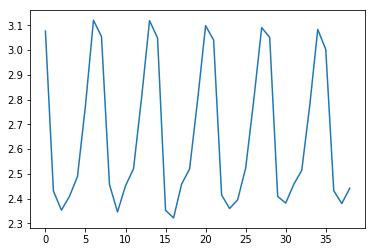

In [32]:
plt.plot(testpreds[129])

In [33]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [34]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.374260   
air_0164b9927d20bcc3_2017-04-23              1.752856   
air_0241aa3964b7f861_2017-04-23              2.266867   
air_0328696196e46f18_2017-04-23              1.922029   
air_034a3d5b40d5b1b1_2017-04-23              3.463745   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   9.743062  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   4.771060  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.649119  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   5.834815  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.936368

In [35]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [36]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [37]:
submission.to_csv("../submission/3005_rf_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')